## Requirements

In [1]:
# Import all required libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_Today_data, save_to_csv, read_from_csv
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from garch import Garch_simulation,get_param_garch
from dupire import get_local_vol_surface, dupire_simulation
from BaseLineGBM import GBM_simulation
from plot_result import plot_s_paths,plot_v_paths,plot_payouts

## Load Data

In [24]:
ticker = "^SPX"
spx = yf.Ticker(ticker)
r = 0.045

calls,date = get_Today_data(Ticker = spx, r = r)
save_to_csv(calls,date)
# calls = read_from_csv("2025-10-28")

print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)
calls.head()

range of strike:  6640.0 7025.0
range of ttm:  0.011904761904761904 0.24206349206349206
number of options:  832


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
0,6705.0,169.90,2025-10-31 00:29:12+00:00,0,2025-11-03,6822.339844,0.011905,2511,0.045,in,6882.155471,-0.68827,0.332192
1,6825.0,59.94,2025-10-31 00:44:25+00:00,0,2025-11-03,6822.339844,0.011905,2511,0.045,out,6882.155471,-0.68827,0.200181
2,6830.0,56.90,2025-10-31 00:51:29+00:00,0,2025-11-03,6822.339844,0.011905,2511,0.045,out,6882.155471,-0.68827,0.198217
3,6840.0,47.90,2025-10-31 01:10:29+00:00,0,2025-11-03,6822.339844,0.011905,2511,0.045,out,6882.155471,-0.68827,0.183720
4,6865.0,33.10,2025-10-31 00:31:56+00:00,0,2025-11-03,6822.339844,0.011905,2511,0.045,out,6882.155471,-0.68827,0.168572


# Methods

## Base Line: Constant Vol GBM

In [25]:
spx = yf.download(ticker, period='31d')
spx['returns'] = np.log(spx['Close'] / spx['Close'].shift(1))
vol = spx['returns'].dropna().std()
vol_annual = vol * np.sqrt(252)
mu = spx['returns'].dropna().mean()
mu_annual = mu * 252
print("Annualized 30-days Mean:",mu_annual)
print("Annualized 30-days Volatility:",vol_annual)

[*********************100%***********************]  1 of 1 completed

Annualized 30-days Mean: 0.23773779159588754
Annualized 30-days Volatility: 0.12476183688558365


## Local Volitality Method

### Get Interpolation and Regression (as comparison)

In [26]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

### Find and Plot Local Volitality

#### Local Vol using Interpolation

In [27]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)

#### local Vol using regression

In [28]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

## Heston Method

In [29]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


## Garch Method

In [30]:
omega, alpha, beta = get_param_garch(ticker)
print("Omega:",omega)
print("Alpha:",alpha)
print("Beta:",beta)

[*********************100%***********************]  1 of 1 completed

Omega: 7.983814109427158e-06
Alpha: 0.04999999831833821
Beta: 0.899999999547471


# Path Simulated And Results Comparison

## Set Up parameters

In [31]:
# Exercise price
K = 7500
# time in years
T = 0.5
# number of time steps in simulation
N = int(T*252)
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate
q = 0
# number of simulations
M = 100


## Plot Paths

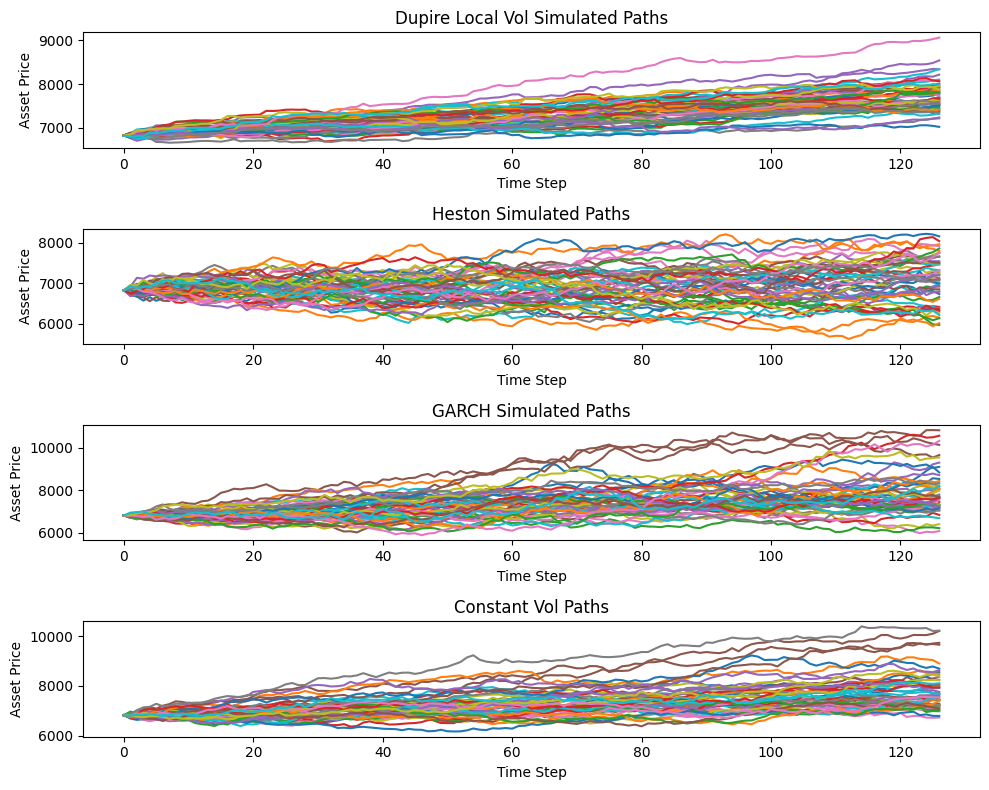

In [32]:
S_path_Heston,V_path_Heston = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,M=M,N=N)
S_path_dupire,V_path_dupire = dupire_simulation(mu_annual=mu_annual,K=K,S0=S0,T=T,N=N,M=M, params=[calls["S0"].iloc[0],calls["r"].iloc[0],interp])
S_path_Garch, V_path_Garch = Garch_simulation(omega=omega, alpha=alpha, beta=beta,mu_annual=mu_annual,vol_annual=vol_annual,N=N,M=M,S0=S0,T=T)
S_path_GBM, V_path_GBM = GBM_simulation(vol_annual=vol_annual,mu_annual=mu_annual,S0=S0,T=T,N=N,M=M)

plot_s_paths(S_path_dupire,S_path_Heston,S_path_Garch,S_path_GBM,m=50)


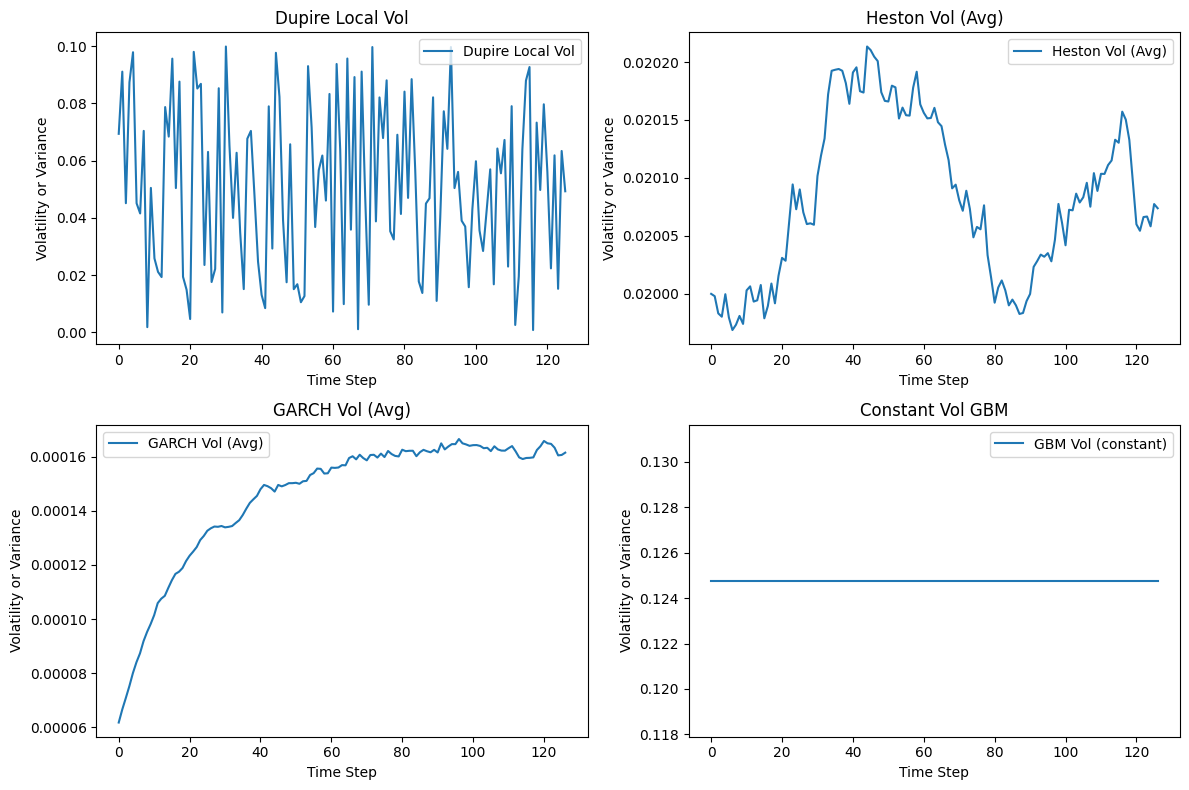

In [33]:
plot_v_paths(V_path_dupire,V_path_Heston,V_path_Garch,V_path_GBM)

## Plot PAYOFF Distribution

In [34]:
def payout(path,K):
    return np.maximum(path[-1,:]-K,0)

def DCF(payout,r,T):
    return payout*np.exp(-r*T)
local_vol_payouts = payout(S_path_dupire,K)
heston_payouts = payout(S_path_Heston,K)
Garch_Vol_payouts = payout(S_path_Garch,K)
Constant_vol_payouts = payout(S_path_GBM,K)

local_vol_val = DCF(local_vol_payouts,r,T)
heston_val = DCF(heston_payouts,r,T)
Garch_Vol_val = DCF(Garch_Vol_payouts,r,T)
Constant_vol_val = DCF(Constant_vol_payouts,r,T)

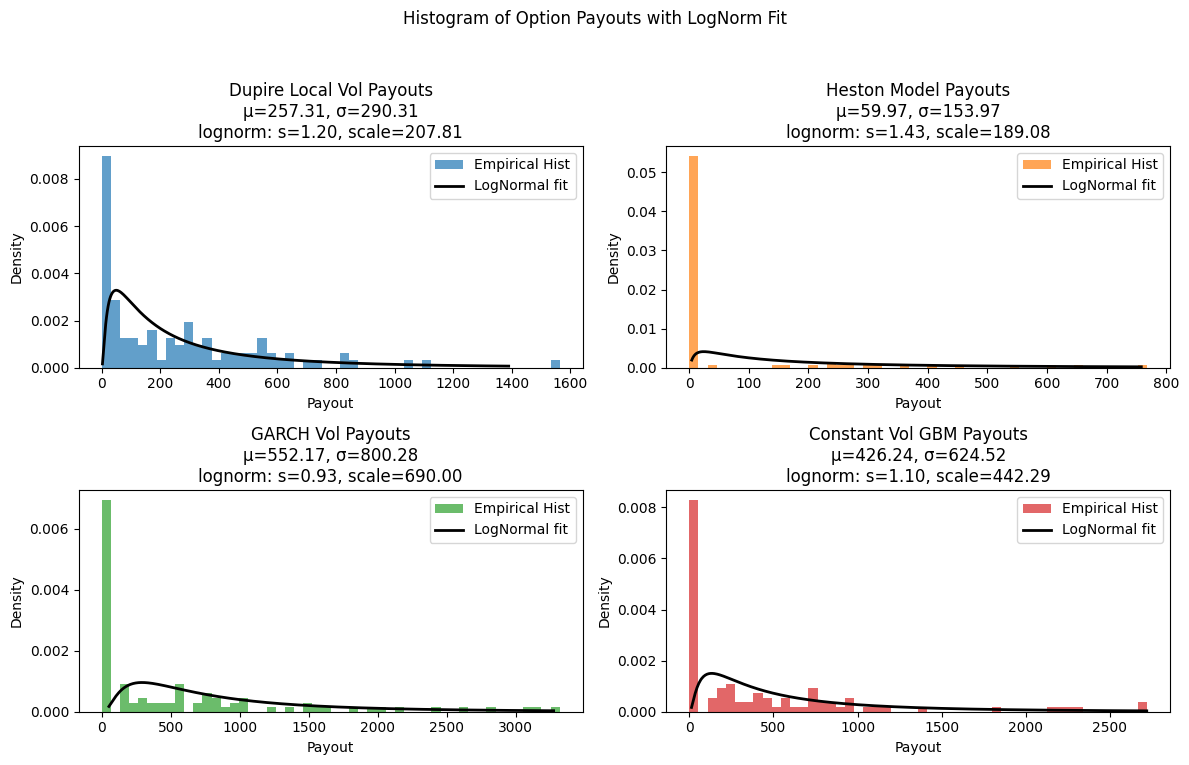

In [35]:
plot_payouts(local_vol_payouts,heston_payouts,Garch_Vol_payouts,Constant_vol_payouts)

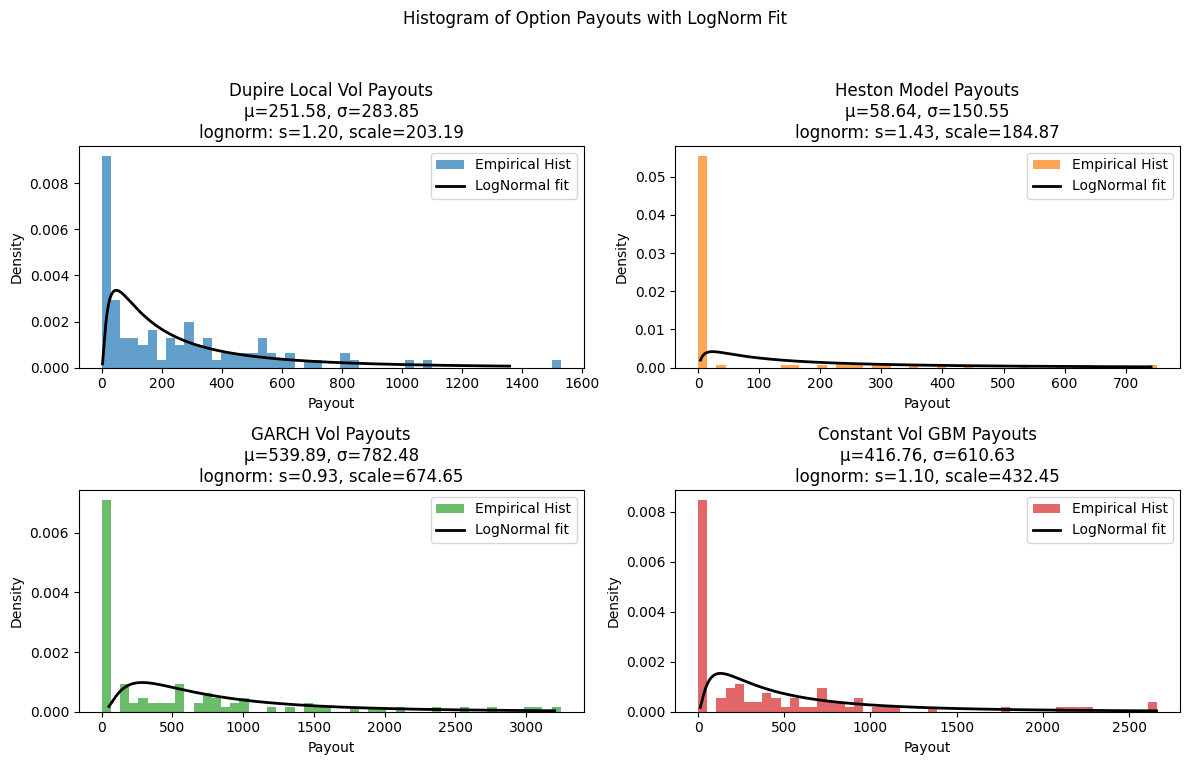

In [36]:
plot_payouts(local_vol_val,heston_val,Garch_Vol_val,Constant_vol_val)
